# Imports

In [11]:
# Imports
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import cv2
import numpy as np
np.random.seed(7)

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# Image Paths
content_path = '/content/drive/MyDrive/Colab Notebooks/Portfolio/NST/imgs/nst_content.jpg'
style_path = '/content/drive/MyDrive/Colab Notebooks/Portfolio/NST/imgs/nst_style.jpeg'

# Execution Paramters
style_weight = 30
content_weight = 100
epochs = 20
steps = 100


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Images

In [12]:
# Function to preprocess images to be compatible with the model
def load_img(img_path):
    '''returns tensor of image with shape (1, 400, 400, 3)'''
    img = cv2.imread(img_path)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [400, 600])
    img = img[tf.newaxis, :]
    return img

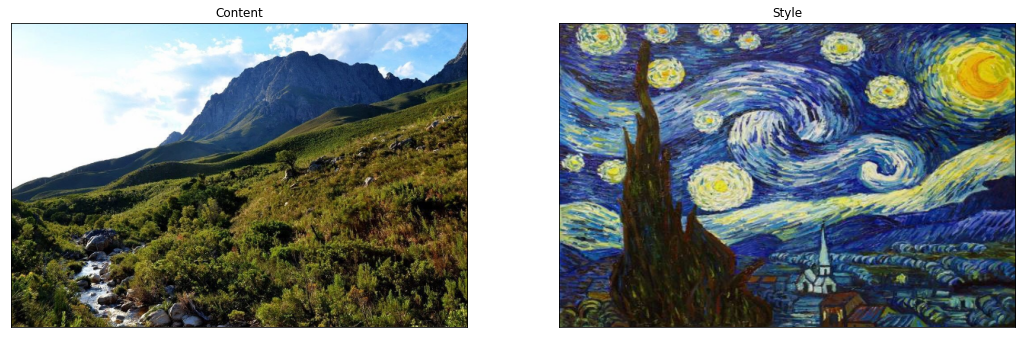

In [59]:
# Preprocess content & style images
content_img = load_img(content_path)
style_img = load_img(style_path)

# View images
_, (content_plt, style_plt) = plt.subplots(1, 2, figsize=(18,9))

# cvtColor as plt switches R & B and cv2.imshow doesn't work in colab
# np.float32 as plt doesn't accept tf tensors
content_plt.imshow(cv2.cvtColor(np.float32(content_img[0]), cv2.COLOR_BGR2RGB))
content_plt.set_title('Content')
content_plt.set_xticks([])
content_plt.set_yticks([])

style_plt.imshow(cv2.cvtColor(np.float32(style_img[0]), cv2.COLOR_BGR2RGB))
style_plt.set_title('Style')
style_plt.set_xticks([])
style_plt.set_yticks([])

plt.show()

# Model


In [14]:
# Load the VGG19 model, no output & not trainable
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


In [15]:
# View model layers 
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
# VGG model which returns each specified layer 
def model_layers(model, layers):
    '''returns a keras model which outputs each specified layer'''
    outputs = [model.get_layer(layer).output for layer in layers]
    return Model([model.input], outputs)

# Neural Style Transfer

The style or gram matrix can be calculated for a layer using the equation:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


You can use tf.linalg.einsum for element-wise computations:

In [17]:
# Style/Gram matrix
def style_matrix(tensor):
    numerator = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    denominator = tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32)
    return numerator/denominator 

In [18]:
# Model class which returns the style & content layer values
class ContentStyleModel(Model):
    def __init__(self, style_layers, content_layers):
        super(ContentStyleModel, self).__init__()
        self.vgg = model_layers(vgg, style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def __call__(self, inputs):
        '''returns style & content values: 
        {'style': style_dict, 'content': content_dict}'''

        # preprocess & get layers/outputs
        inputs = preprocess_input(inputs*255.0)
        outputs = self.vgg(inputs)

        # split style & content layers
        style_outs = outputs[:self.num_style_layers]
        content_outs = outputs[self.num_style_layers:]

        # apply style matrix to each layer
        style_outs = [style_matrix(out) for out in style_outs]

        # build content & style {layer:value} dictionaries
        style_dict = {name:val for name, val in zip(self.style_layers, style_outs)}
        content_dict = {name:val for name, val in zip(self.content_layers, content_outs)}

        # return dict of both dicts
        return {'style': style_dict, 'content': content_dict}

In [19]:
# Define content & style layers as defined in Gatys et al. (https://arxiv.org/abs/1508.06576) 
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Initialise ContentStyleModel() class
content_style_model = ContentStyleModel(style_layers, content_layers)
# Extract style & content targets
style_targets = content_style_model(style_img)['style']
content_targets = content_style_model(content_img)['content']

In [44]:
# Define content & style weights

style_weights = {'block1_conv1': 0.2,
                 'block2_conv1': 0.2,
                 'block3_conv1': 0.2,
                 'block4_conv1': 0.2,
                 'block5_conv1': 0.2}

# Loss Function

In [45]:
# Adam to optimize loss function
optimizer = Adam(learning_rate=2e-2)

# Loss function to optimize
def content_style_loss(output_dict):
    '''parameter output_dict = output from ContentStyleModel() class: {'style': style_dict, 'content': content_dict}
    returns total loss, style + content'''

    style_out = output_dict['style']
    content_out = output_dict['content']

    # Total losses
    style_loss = tf.add_n([style_weights[name] * tf.reduce_mean((style_out[name] - style_targets[name])**2) 
                            for name in style_out.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_out[name] - content_targets[name])**2)
                            for name in content_out.keys()])
    
    # Normalize
    style_loss *= style_weight / len(style_layers) 
    content_loss *= content_weight / len(content_layers)

    # Total
    return style_loss + content_loss

# Execution

In [46]:
# function to update the generated image
@tf.function()
def update_img(image):
    '''performs a single update step on image'''
    with tf.GradientTape() as tape:
        # process image & calculate loss
        outs = content_style_model(image)
        loss = content_style_loss(outs)

    # gradient with respect to image
    m = tape.gradient(loss, image)
    # optimize image
    optimizer.apply_gradients([(m, image)])
    # normalize so that 0 < pixels < 1
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

In [47]:
# Create tf.Variable of image to optimise
image = tf.Variable(content_img)

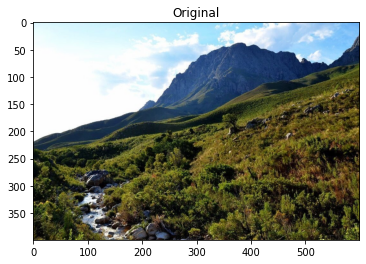


epoch 1..................................................
epoch 2..................................................
epoch 3..................................................
epoch 4..................................................
epoch 5..................................................

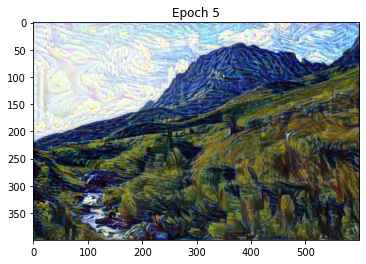


epoch 6..................................................
epoch 7..................................................
epoch 8..................................................
epoch 9..................................................
epoch 10..................................................

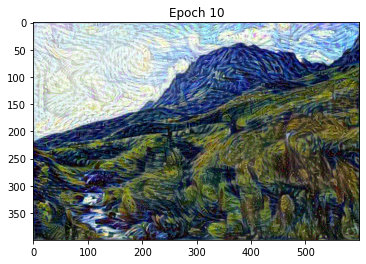


epoch 11..................................................
epoch 12..................................................
epoch 13..................................................
epoch 14..................................................
epoch 15..................................................

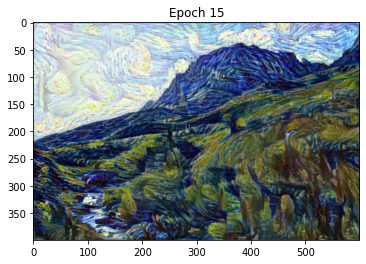


epoch 16..................................................
epoch 17..................................................
epoch 18..................................................
epoch 19..................................................
epoch 20..................................................

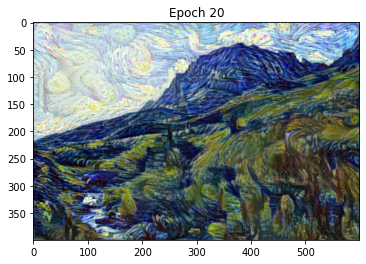

In [48]:
epochs = 20
steps = 100

count = 0

# Show original first
plt.imshow(cv2.cvtColor(np.float32(image[0]), cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

# Process image
for epoch in range(epochs):
    print()
    print(f'epoch {epoch+1}', end='')
    for step in range(steps):
        if step%2==0: print('.', end='')
        count += 1
        update_img(image)
    if (epoch+1) % 5 == 0: # view every 5 epochs
        plt.imshow(cv2.cvtColor(np.float32(image[0]), cv2.COLOR_BGR2RGB))
        plt.title(f'Epoch {epoch+1}')
        plt.show()

# Result

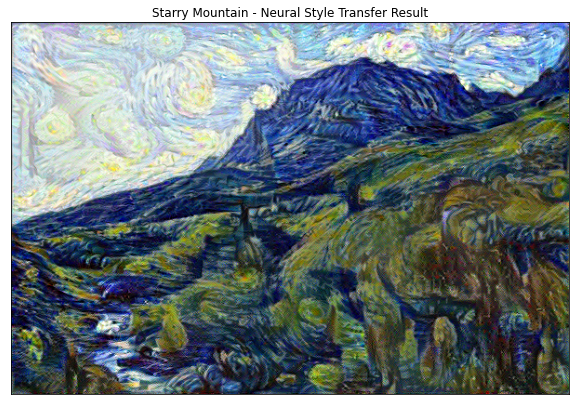

In [58]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(np.float32(image[0]), cv2.COLOR_BGR2RGB))
plt.title('Starry Mountain - Neural Style Transfer Result')

plt.show()